In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import splitfolders

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 400
EPOCHS = 5

In [3]:
train_dir = "../Animals-10_Project/output/train/"
test_dir = "../Animals-10_Project/output/test/"
val_dir = "../Animals-10_Project/output/val/"

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size = (IMG_SIZE,IMG_SIZE),
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size = (IMG_SIZE,IMG_SIZE)
)

Found 20938 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.


In [6]:
class_names = [indice for indice in train_generator.class_indices]
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


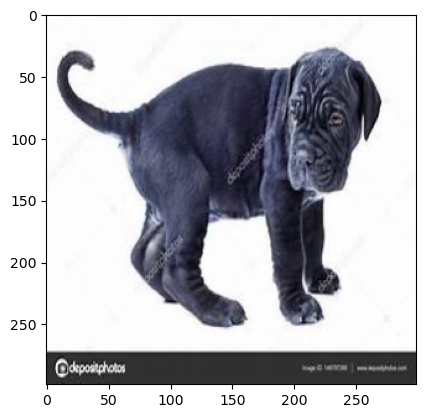

In [7]:
import os
import cv2

for name in class_names:
    path = os.path.join(train_dir, name)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (299, 299))
        plt.imshow(new_array)
        plt.show()
        break
    break

In [8]:
inception_model_3 = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
inception_model_3.trainable=False

for layer in inception_model_3.layers:
    print(layer.name, layer.trainable)

input_1 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
activati

In [9]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')
x = inception_model_3(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
new_model_4 = tf.keras.Model(inputs, outputs)

In [10]:
new_model_4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
history_4 = new_model_4.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator,
    validation_steps=(0.25 * len(val_generator)),
)

Epoch 1/3
655/655 [==============================] - 462s 682ms/step - loss: 0.2209 - accuracy: 0.9566 - val_loss: 0.0908 - val_accuracy: 0.9792
Epoch 2/3
655/655 [==============================] - 442s 674ms/step - loss: 0.0761 - accuracy: 0.9799 - val_loss: 0.0876 - val_accuracy: 0.9792
Epoch 3/3
655/655 [==============================] - 332s 507ms/step - loss: 0.0606 - accuracy: 0.9845 - val_loss: 0.1031 - val_accuracy: 0.9792


In [12]:
new_model_4.evaluate(test_generator)

83/83 [==============================] - 44s 526ms/step - loss: 0.0747 - accuracy: 0.9806


[0.07473108172416687, 0.9805862307548523]

In [13]:
def load_and_prep_image(filename, img_shape=IMG_SIZE, scale=True):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        return img/255.
    else:
        return img

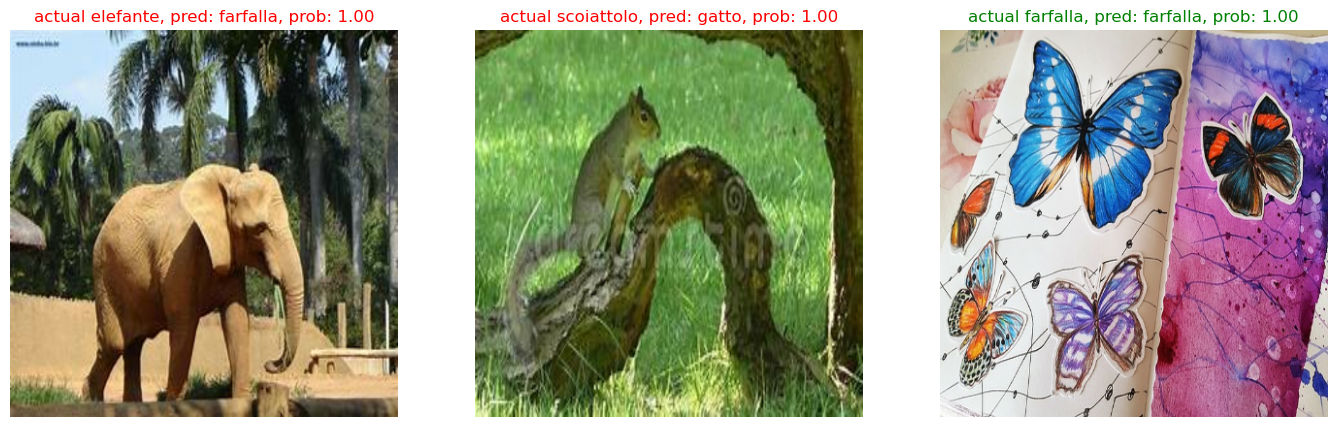

In [23]:
import random

plt.figure(figsize=(17,10))
for i in range(3):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename
    #print(img.shape)
    #print(tf.expand_dims(img, axis=0).shape)
    img = load_and_prep_image(filepath, scale=False)
    pred_prob = new_model_4.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    #print(pred_prob)
    #print(pred_class)
    plt.subplot(1,3,i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:
        title_color = 'g'
    else:
        title_color = 'r'
    
    plt.title(f"actual {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

In [15]:
y_val = test_generator.classes
y_pred = new_model_4.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       487
           1       0.98      0.98      0.98       263
           2       0.99      1.00      1.00       146
           3       0.97      1.00      0.98       212
           4       0.99      0.98      0.99       311
           5       0.98      0.98      0.98       168
           6       0.98      0.93      0.96       188
           7       0.91      0.99      0.95       182
           8       1.00      0.98      0.99       483
           9       0.99      0.99      0.99       187

    accuracy                           0.98      2627
   macro avg       0.98      0.98      0.98      2627
weighted avg       0.98      0.98      0.98      2627



In [17]:
class_indices = test_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

filenames = test_generator.filenames

In [18]:
test_df = pd.DataFrame()
test_df['filename'] = filenames
test_df['actual'] = y_val
test_df['predicted'] = y_pred
test_df['actual'] = test_df['actual'].apply(lambda x: indices[x])
test_df['predicted'] = test_df['predicted'].apply(lambda x: indices[x])
test_df.loc[test_df['actual']==test_df['predicted'],'Same'] = True
test_df.loc[test_df['actual']!=test_df['predicted'],'Same'] = False
test_df.head(10)

filename actual predicted   Same
0      cane\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg   cane      cane   True
1  cane\OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg   cane      cane   True
2  cane\OIP--6UY_QQC69uZF4CrwEcfUQHaHa.jpeg   cane      cane   True
3  cane\OIP--AzXmxzRD9y3THnVByTtLwHaG5.jpeg   cane  farfalla  False
4  cane\OIP--DqSseJFuaBH5t89CubEwAHaE8.jpeg   cane      cane   True
5  cane\OIP--jqyES48oZ9OFI3kFadEggHaEk.jpeg   cane      cane   True
6  cane\OIP--qln8OiJUfar32CqdwPYSgHaED.jpeg   cane      cane   True
7  cane\OIP-0G1lmzPnTshwQJ_IEMNHgQHaFR.jpeg   cane      cane   True
8  cane\OIP-0XaxVg3aPvQ1Ay9EwygV2AHaHa.jpeg   cane      cane   True
9  cane\OIP-0YnNhp62h77TilEL0A_M0gHaE7.jpeg   cane      cane   True

In [24]:
test_df.Same.value_counts()

True     2576
False      51
Name: Same, dtype: int64

In [19]:
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(IMG_SIZE,IMG_SIZE))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"../Animals-10_Project/output/test/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

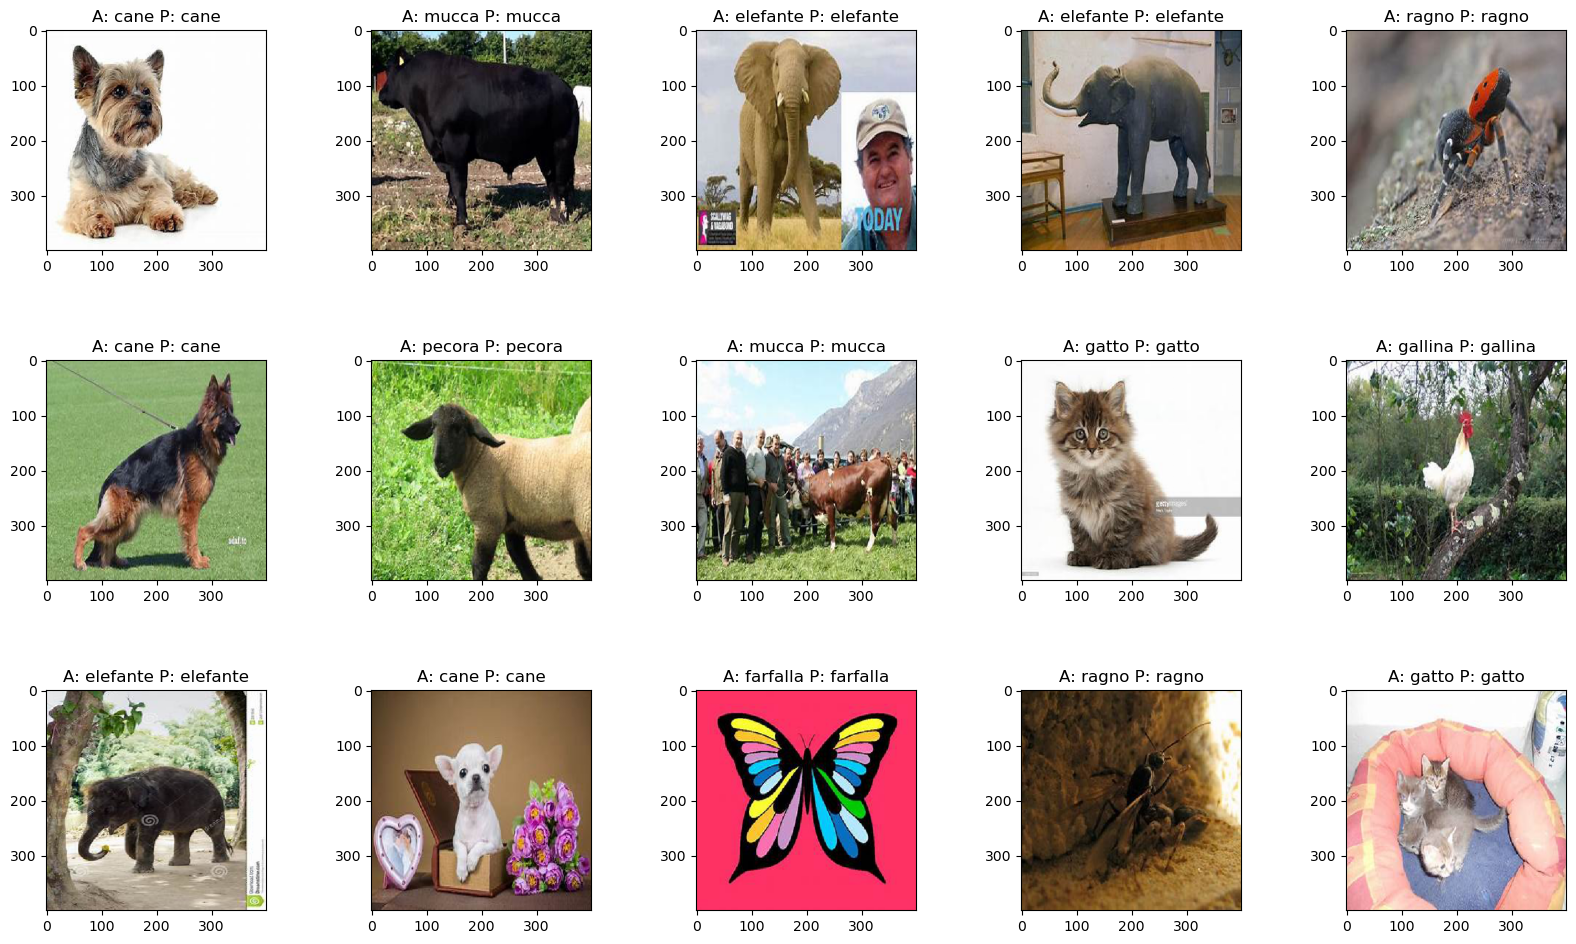

In [21]:
display_images(test_df[test_df['Same']==True])

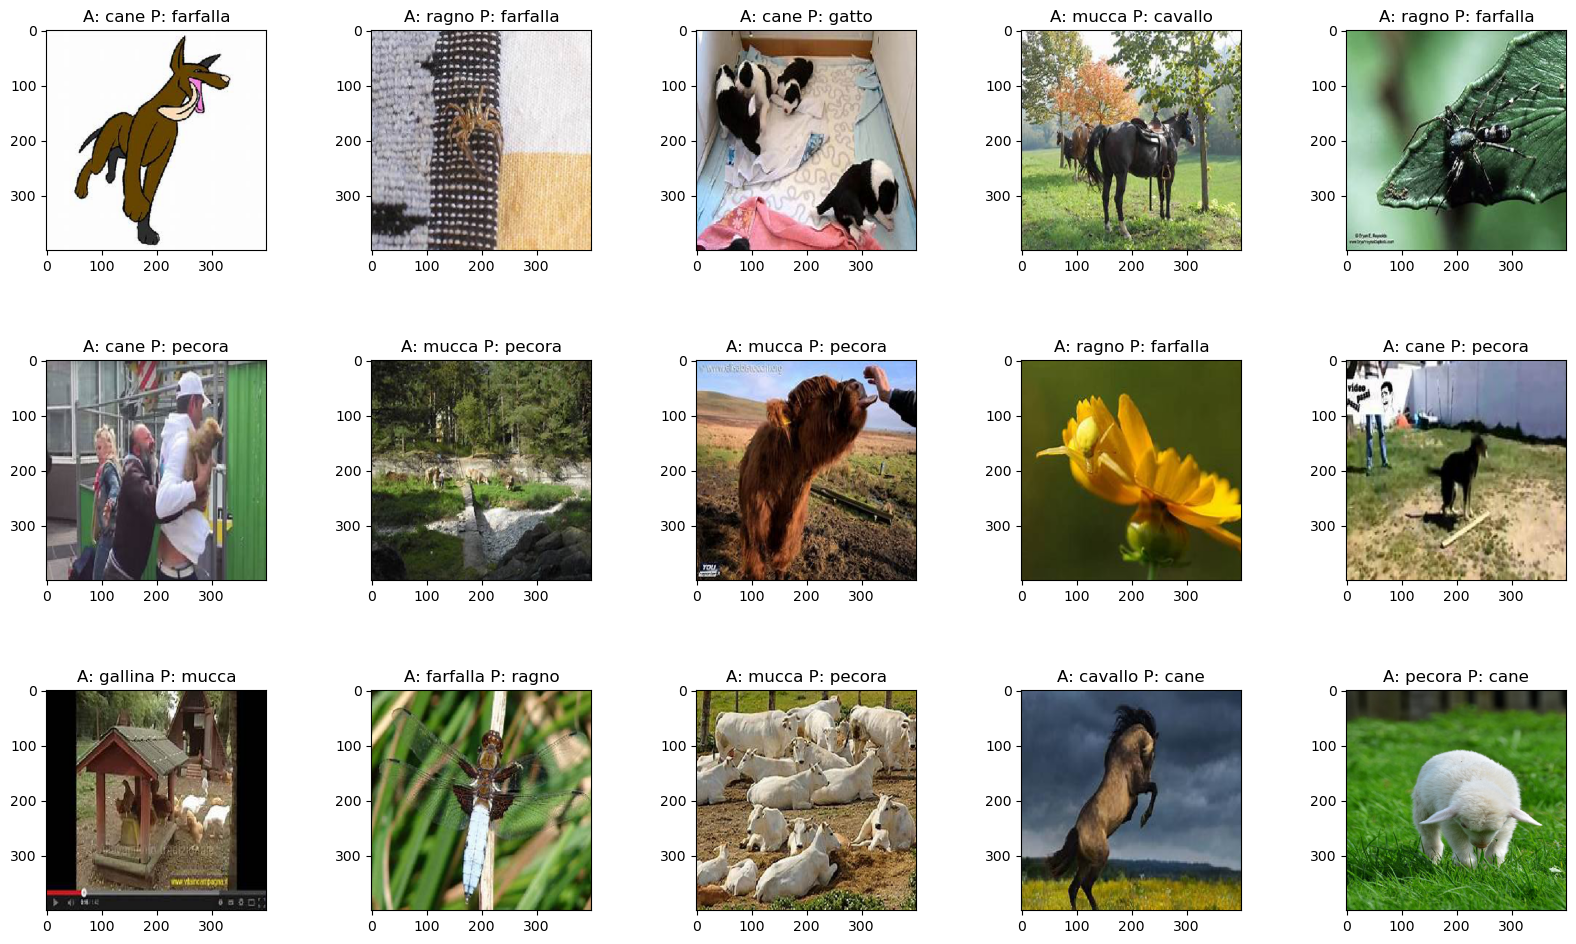

In [22]:
display_images(test_df[test_df['Same']!=True])